In [ ]:
import warnings
warnings.simplefilter(action='ignore')
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import KFold

# Tools/Metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/CME538 Project 2'
os.chdir(path)

Mounted at /content/drive


# 1. Exploratory Data Analysis

In [ ]:
from sklearn.model_selection import KFold # Do we want to use KStratifiedFold here, or is regular KFold fine?
from sklearn.base import clone

def cross_validate(model, x, y):

  """ 
  Input:
    Regression model of choice, X train data set (features only), y train data
    set (target variable only)

  Output:
    List of Cross-validation RMSE scores, Mean of Cross-validation RMSE scores,
    List of MAE scores, Mean of MAE scores, List of R2 scores, Mean of R2 scores

  """

  model = clone(model)
  five_fold = KFold(n_splits = 5, shuffle = True, random_state = 0)
  RMSE_scores = []
  MAE_scores = []
  R2_scores = []

  for train_index, val_index in five_fold.split(x,y):
        
        X_train, y_train = x.iloc[train_index], y.iloc[train_index]
        X_val, y_val =  x.iloc[val_index], y.iloc[val_index]
        
        # Fit model
        model.fit(X_train, y_train)
        y_fitted = model.predict(X_train)
        y_predicted = model.predict(X_val)
    
        # Append RMSE, MAE, and R2 scores, using val error
        RMSE_scores.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))
        MAE_scores.append(mean_absolute_error(y.iloc[val_index], y_predicted))
        R2_scores.append(r2_score(y.iloc[val_index], y_predicted))

  print('CV RMSE scores mean: {}\n'.format(np.mean(RMSE_scores).round(4)),
        'CV MAE scores mean: {}\n'.format(np.mean(MAE_scores).round(4)),
        'CV R2 scores mean: {}\n'.format(np.mean(R2_scores).round(4)))

In [ ]:
df = pd.read_csv('dpoy_player_team_stats_1984_2022_final.csv')
df.head()

Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP   PTS  \
0  Sidney Moncrief   26  MIL   19.0     19.0       76  0.250  79  38.9  20.9   
1       Mark Eaton   27  UTA   14.0     14.0       76  0.184  82  26.1   5.6   
2   Dennis Johnson   29  BOS    7.0      7.0       76  0.092  80  33.3  13.2   
3   Maurice Cheeks   27  PHI    5.0      5.0       76  0.066  75  33.3  12.7   
4   Michael Cooper   27  LAL    5.0      5.0       76  0.066  82  29.1   9.0   

   ...  Team_Off-eFG%  Team_Off-TOV%  Team_ORB%  Team_Off-FT/FGA  \
0  ...          0.497           15.0       33.7            0.250   
1  ...          0.505           15.2       30.8            0.292   
2  ...          0.504           14.6       34.2            0.264   
3  ...          0.497           16.9       34.6            0.299   
4  ...          0.536           16.1       33.7            0.236   

   Team_Def-eFG%  Team_Def-TOV%  Team_DRB%  Team_Def-FT/FGA     Team_Arena  \
0          0.459           14.7       65.6            0.266    MECCA Arena   
1          0.479           13.9       63.4            0.229    Salt Palace   
2          0.475           13.8       69.7            0.225  Boston Garden   
3          0.484           16.0       65.9            0.246   The Spectrum   
4          0.487           14.3       66.6            0.232      The Forum   

   Team_Attend.  
0       393,301  
1       400,065  
2       606,857  
3       588,139  
4       622,401  

[5 rows x 80 columns]

In [ ]:
def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share"]

    X.drop('Share', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [ ]:
df_mi = df.copy()
#df_mi.drop(['Player', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Pos'], axis=1, inplace=True)
df_mi = df[['Share', 'G', 'MP', 'STL', 'BLK', 'WS/48', 'GS', 'DRB', 'PF', 'VORP', 'DWS', 'STL%', 'DBPM', 'BLK%', 'DRB%', 'BPM', 'PER', 'OWS', '3PAr', 'ORB%', 'OBPM', 'TS%', 'TRB%', 'TOV%', 'Team_W', 'Team_PL', 'Team_DRtg', 'Team_NRtg', 'Team_Def-eFG%', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA']]

In [ ]:
X, y, mi_scores = calculate_ml_scores(df=df_mi)

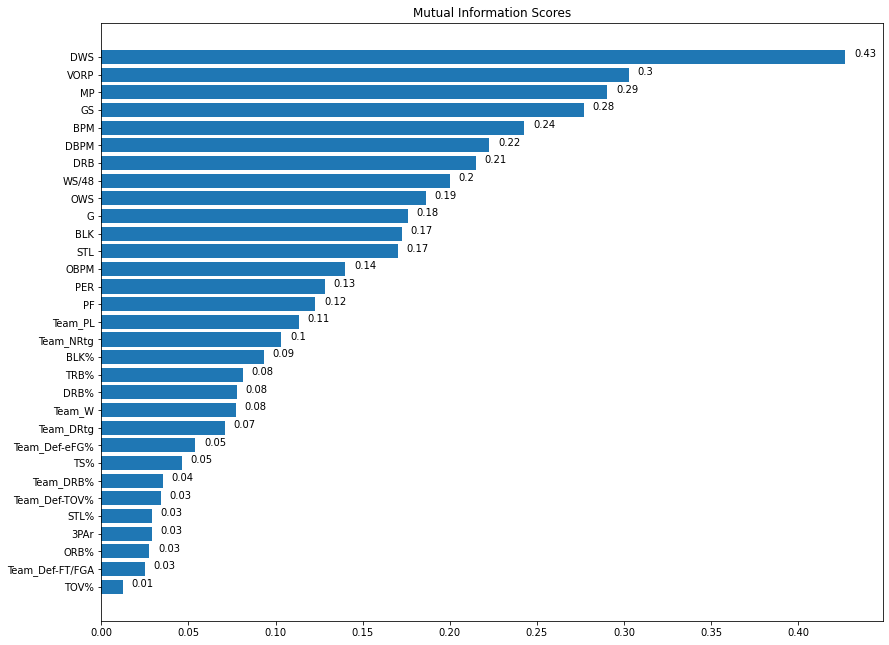

In [ ]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))

In [ ]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def ohe_position(data):
    """
    One-hot-encodes position.
    New columns are of the form Pos_Name
    """
    # List Position Names
    names = ['PG',
             'SG',
             'SF',
             'PF',
             'C']

    category_type = pd.CategoricalDtype(categories=names)
    data.loc[:, 'Pos'] = data.loc[:, 'Pos'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='Position',
                          columns=['Pos'], 
                          drop_first=True)
    
    return data

def process_data(data):
    """Process the data for a guided model."""
    # Transform Data, Select Features
    pys = data[['Player','Year','Share']]
    data['has_share'] = data['Share'].map(lambda x: int(x > 0))
    data['Team_Attend.'] = data['Team_Attend.'].map(lambda x: int(x.replace(',','')))
    data['Team_W/L'] = data['Team_W']/82
    #data['BLK,STL'] = max(data['BLKn'],data['STLn']) #normalize BLK and STL and compare to average
    data = ohe_position(data)
    data = select_columns(data, 
                          #'Age', 'Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Year', 'GS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TOV', 'PF', 'VORP', 'DWS', 'USG%', 'AST%', 'STL%', 'DBPM', 'FTr', 'BLK%', 'DRB%', 'BPM', 'PER', 'OWS', '3PAr', 'ORB%', 'OBPM', 'TS%', 'TRB%', 'TOV%', 'Team_Age', 'Team_W', 'Team_L', 'Team_PW', 'Team_PL', 'Team_MOV', 'Team_SOS', 'Team_SRS', 'Team_ORtg', 'Team_DRtg', 'Team_NRtg', 'Team_Pace', 'Team_FTr', 'Team_3PAr', 'Team_TS%', 'Team_Off-eFG%', 'Team_Off-TOV%', 'Team_ORB%', 'Team_Off-FT/FGA', 'Team_Def-eFG%', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA', 'Team_Attend.', 'Position_SG', 'Position_SF', 'Position_PF', 'Position_C' # All parameters
                          #'Share' ,'Age', 'G', 'MP', 'TRB', 'STL', 'STL%', 'BLK', 'BLK%', 'WS', 'WS/48', 'Position_SG', 'Position_SF', 'Position_PF', 'Position_C', 'Team_W/L', 'GS', 'DRB', 'PF', 'DRB%', 'DWS', 'DBPM', 'has_share' #Sammy recommmended
                          #'Share', 'G', 'MP', 'PTS', 'TRB', 'STL', 'BLK', 'WS/48', 'GS', '2P%', 'eFG%', 'FTA', 'DRB', 'PF', 'VORP', 'DWS', 'USG%', 'STL%', 'DBPM', 'FTr', 'BLK%', 'DRB%', 'BPM', 'PER', 'OWS', '3PAr', 'ORB%', 'OBPM', 'TS%', 'TRB%', 'TOV%', 'Team_W', 'Team_PL', 'Team_DRtg', 'Team_NRtg', 'Team_FTr', 'Team_TS%', 'Team_Off-eFG%', 'Team_ORB%', 'Team_Def-eFG%', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA', 'Team_Attend.' 'has_share', 'Position_SG', 'Position_SF', 'Position_PF', 'Position_C' # Cut Down
                          'Share', 'G', 'MP', 'STL', 'BLK', 'WS/48', 'GS', 'DRB', 'PF', 'VORP', 'DWS', 'STL%', 'DBPM', 'BLK%', 'DRB%', 'BPM', 'OWS', '3PAr', 'ORB%', 'TS%', 'TRB%', 'Team_W/L', 'Team_PL', 'Team_DRtg', 'Team_NRtg', 'Team_Def-eFG%', 'Team_Def-TOV%', 'Team_DRB%', 'Team_Def-FT/FGA', 'Team_Attend.', 'Position_SG', 'Position_SF', 'Position_PF', 'Position_C'
    )
    #Normalization
    for column in data.columns.tolist():
      data[column] = (data[column] - data[column].min())/(data[column].max() - data[column].min())
    X = data.drop(['Share'], axis = 1)
    Y = data.loc[:, 'Share']
    return X, Y, pys

In [ ]:
train_df = df[(df['Year'] < 2022)]
test_df = df[df['Year'] >= 2022]
X_train, y_train, pys_train = process_data(train_df)
X_test, y_test, pys_test = process_data(test_df)

In [ ]:
random_forest = RandomForestRegressor(random_state = 0)
cross_validate(random_forest, X_train, y_train)

CV RMSE scores mean: 0.1046
 CV MAE scores mean: 0.0466
 CV R2 scores mean: 0.44



Baseline (all features, not considering players without share): 0.1459, 0.0908, 0.3394.

Baseline (all features): 0.1027, 0.0462, 0.4579


G        MP       STL       BLK     WS/48        GS  \
G                1.000000  0.556507  0.447599  0.334955  0.384480  0.739058   
MP               0.556507  1.000000  0.746314  0.487816  0.629691  0.831713   
STL              0.447599  0.746314  1.000000  0.239204  0.492782  0.634484   
BLK              0.334955  0.487816  0.239204  1.000000  0.490041  0.475691   
WS/48            0.384480  0.629691  0.492782  0.490041  1.000000  0.560680   
GS               0.739058  0.831713  0.634484  0.475691  0.560680  1.000000   
DRB              0.440743  0.731509  0.448878  0.786384  0.640301  0.667267   
PF               0.467657  0.547608  0.400926  0.605107  0.379195  0.548779   
VORP             0.525306  0.835884  0.727921  0.500985  0.845266  0.747070   
DWS              0.657272  0.797582  0.626413  0.666704  0.727574  0.804629   
STL%             0.120604  0.257581  0.767986 -0.109149  0.183629  0.186381   
DBPM             0.266774  0.361428  0.471143  0.550096  0.565529  0.383498   
BLK%             0.091994  0.142433 -0.057696  0.890886  0.299746  0.172419   
DRB%             0.104130  0.211851 -0.032051  0.677743  0.384294  0.217916   
BPM              0.423459  0.742852  0.691308  0.488191  0.892379  0.636820   
PER              0.341595  0.696639  0.567161  0.517031  0.887010  0.569649   
OWS              0.561761  0.797281  0.609941  0.401300  0.865284  0.721014   
3PAr             0.002419  0.041795  0.224815 -0.378534 -0.113277 -0.010859   
ORB%             0.056059  0.028415 -0.166030  0.553660  0.248483  0.074525   
OBPM             0.406744  0.758513  0.635259  0.345001  0.839605  0.614374   
TS%              0.286010  0.368959  0.228597  0.323189  0.724217  0.354337   
TRB%             0.086853  0.148034 -0.096359  0.673479  0.363748  0.172698   
Team_W           0.308305  0.258452  0.183452  0.118445  0.455339  0.323988   
Team_PL         -0.163854 -0.239347 -0.178397 -0.124701 -0.497433 -0.257572   
Team_DRtg       -0.155745 -0.214929 -0.096649 -0.117731 -0.335316 -0.236902   
Team_NRtg        0.235361  0.252021  0.184305  0.126863  0.500437  0.298252   
Team_Def-eFG%   -0.204258 -0.183132 -0.021571 -0.104231 -0.231834 -0.198933   
Team_Def-TOV%    0.115201  0.072383  0.198784 -0.080424 -0.005972  0.085710   
Team_DRB%       -0.156070 -0.020098 -0.044981  0.101852  0.193650 -0.003439   
Team_Def-FT/FGA  0.092663 -0.060037  0.026148 -0.116165 -0.184770 -0.037423   
Team_Attend.     0.133157  0.119185  0.010483  0.051185  0.219348  0.146555   
Position_SG      0.052246  0.032151  0.134040 -0.237546 -0.081547  0.020838   
Position_SF      0.013238  0.048200  0.069963 -0.063679 -0.054440  0.029241   
Position_PF     -0.008584 -0.015789 -0.090870  0.136322  0.012386 -0.039032   
Position_C      -0.003022 -0.041357 -0.253126  0.478687  0.144735  0.043321   

                      DRB        PF      VORP       DWS  ...  Team_NRtg  \
G                0.440743  0.467657  0.525306  0.657272  ...   0.235361   
MP               0.731509  0.547608  0.835884  0.797582  ...   0.252021   
STL              0.448878  0.400926  0.727921  0.626413  ...   0.184305   
BLK              0.786384  0.605107  0.500985  0.666704  ...   0.126863   
WS/48            0.640301  0.379195  0.845266  0.727574  ...   0.500437   
GS               0.667267  0.548779  0.747070  0.804629  ...   0.298252   
DRB              1.000000  0.661261  0.688263  0.826726  ...   0.199949   
PF               0.661261  1.000000  0.418086  0.608072  ...   0.067665   
VORP             0.688263  0.418086  1.000000  0.833908  ...   0.431002   
DWS              0.826726  0.608072  0.833908  1.000000  ...   0.447462   
STL%            -0.009607  0.033320  0.360087  0.215841  ...   0.052746   
DBPM             0.493143  0.355832  0.597136  0.662798  ...   0.354498   
BLK%             0.550336  0.386006  0.225730  0.397606  ...   0.054017   
DRB%             0.760243  0.413844  0.273334  0.462116  ...   0.043994   
BPM              0.644024  0.364554  0.945915  0.76660

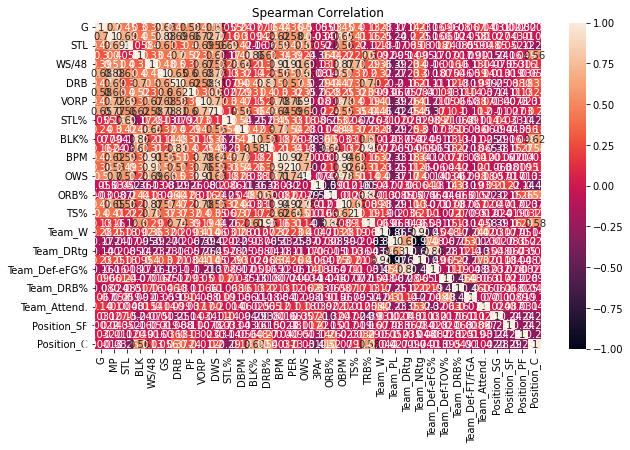

In [ ]:
def display_correlation(df, method):
    r = df.corr(method=method)
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)
display_correlation(X_train, method = "spearman")

Remove either defensive rebounds of total rebounds because highly correlated.
Same for GS / Minutes played.
DWS and WS.


Text(27.758984375000004, 0.5, 'Blocks per Game')

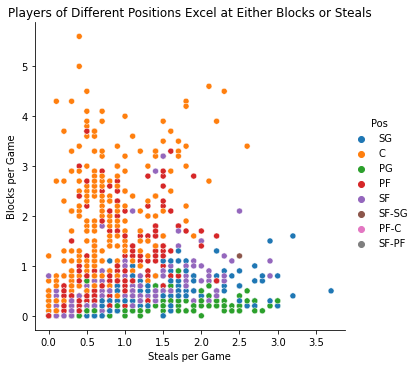

In [ ]:
sns.relplot(y="BLK", x="STL", hue = 'Pos', data=df)
plt.title('Players of Different Positions Excel at Either Blocks or Steals')
plt.xlabel('Steals per Game')
plt.ylabel('Blocks per Game')

Text(29.51354166666666, 0.5, 'Steals per Game')

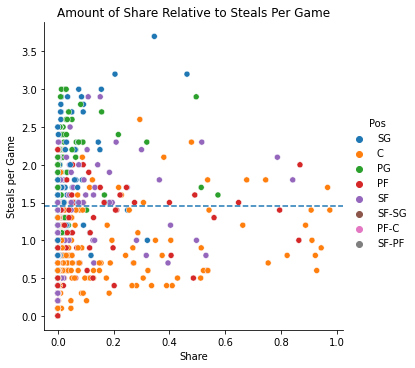

In [ ]:
temp = df.copy()

ax = sns.relplot(data = temp, x = "Share", y = "STL", hue = 'Pos')
plt.axhline(temp['STL'].quantile(0.75), ls = '--')
plt.title('Amount of Share Relative to Steals Per Game')
plt.xlabel('Share')
plt.ylabel('Steals per Game')

Text(0, 0.5, 'Defensive Win Share')

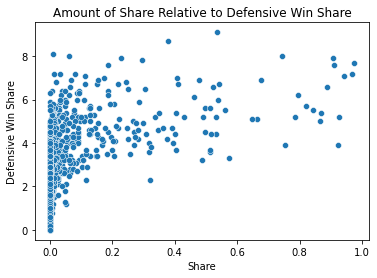

In [ ]:
temp = df.copy()
temp['Team_Attend.'] = temp['Team_Attend.'].map(lambda x: float(x.replace(',','')))
ax=sns.scatterplot(data = temp, x = "Share", y = "DWS")
plt.title('Amount of Share Relative to Defensive Win Share')
plt.xlabel('Share')
plt.ylabel('Defensive Win Share')

Text(0, 0.5, 'Value over Replacement Player')

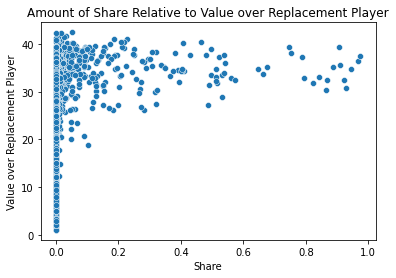

In [ ]:
temp = df.copy()
temp['Team_Attend.'] = temp['Team_Attend.'].map(lambda x: float(x.replace(',','')))
ax=sns.scatterplot(data = temp, x = "Share", y = "MP")
plt.title('Amount of Share Relative to Minutes Played')
plt.xlabel('Share')
plt.ylabel('Minutes Played')

Text(0, 0.5, 'Box Plus Minus')

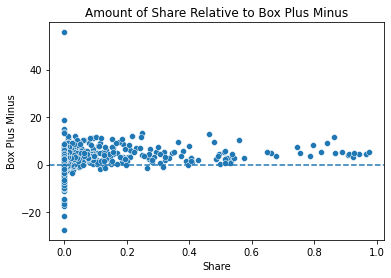

In [ ]:
temp = df.copy()
temp['Team_Attend.'] = temp['Team_Attend.'].map(lambda x: float(x.replace(',','')))
ax=sns.scatterplot(data = temp, x = "Share", y = "BPM")
plt.axhline(0, ls = '--')
plt.title('Amount of Share Relative to Box Plus Minus')
plt.xlabel('Share')
plt.ylabel('Box Plus Minus')

In [ ]:
temp.head()
temp[(temp['Share']>0) & (temp['Team_Attend.']<200000)]

Player  Age   Tm  First  Pts Won  Pts Max  Share   G  \
534               Rudy Gobert   28  UTA   84.0    464.0      500  0.928  71   
535               Ben Simmons   24  PHI   15.0    287.0      500  0.574  58   
536            Draymond Green   30  GSW    0.0     76.0      500  0.152  63   
537               Bam Adebayo   23  MIA    1.0     31.0      500  0.062  64   
538     Giannis Antetokounmpo   26  MIL    0.0     12.0      500  0.024  61   
539              Clint Capela   26  ATL    0.0     10.0      500  0.020  63   
540               Joel Embiid   26  PHI    0.0      7.0      500  0.014  51   
541              Jrue Holiday   30  MIL    0.0      6.0      500  0.012  59   
542              Myles Turner   24  IND    0.0      3.0      500  0.006  47   
543              Jimmy Butler   31  MIA    0.0      2.0      500  0.004  52   
544  Kentavious Caldwell-Pope   27  LAL    0.0      1.0      500  0.002  67   
545          Matisse Thybulle   23  PHI    0.0      1.0      500  0.002  65   

       MP   PTS  ...  Team_Off-eFG%  Team_Off-TOV%  Team_ORB%  \
534  30.8  14.3  ...          0.563           12.7       24.5   
535  32.4  14.3  ...          0.541           12.8       23.2   
536  31.5   7.0  ...          0.551           13.3       17.9   
537  33.5  18.7  ...          0.546           13.1       19.4   
538  33.0  28.1  ...          0.566           12.0       23.3   
539  30.1  15.2  ...          0.539           11.9       24.4   
540  31.1  28.5  ...          0.541           12.8       23.2   
541  32.3  17.7  ...          0.566           12.0       23.3   
542  31.0  12.6  ...          0.542           11.9       20.2   
543  33.6  21.5  ...          0.546           13.1       19.4   
544  28.4   9.7  ...          0.536           13.6       22.5   
545  20.0   3.9  ...          0.541           12.8       23.2   

     Team_Off-FT/FGA  Team_Def-eFG%  Team_Def-TOV%  Team_DRB%  \
534            0.195          0.507           10.3       79.3   
535            0.225          0.521           13.8       78.2   
536            0.188          0.522           13.1       76.6   
537            0.199          0.542           13.8       77.9   
538            0.177          0.536           11.5       79.7   
539            0.226          0.530           11.1       77.8   
540            0.225          0.521           13.8       78.2   
541            0.177          0.536           11.5       79.7   
542            0.180          0.531           12.7       74.9   
543            0.199          0.542           13.8       77.9   
544            0.200          0.526           13.7       79.7   
545            0.225          0.521           13.8       78.2   

     Team_Def-FT/FGA               Team_Arena  Team_Attend.  
534            0.159  Vivint Smart Home Arena      151300.0  
535            0.200       Wells Fargo Center       68583.0  
536            0.223             Chase Center       33457.0  
537            0.183   AmericanAirlines Arena           0.0  
538            0.157             Fiserv Forum       64780.0  
539            0.190         State Farm Arena       59288.0  
540            0.200       Wells Fargo Center       68583.0  
541            0.157             Fiserv Forum       64780.0  
542            0.201  Bankers Life Fieldhouse           0.0  
543            0.183   AmericanAirlines Arena           0.0  
544            0.184           STAPLES Center       23313.0  
545            0.200       Wells Fargo Center       68583.0  

[12 rows x 80 columns]

In [ ]:
sns.relplot(data = temp, x = "Share", y = "BLK", hue = 'Pos')
plt.axhline(temp['STL'].quantile(0.75), ls = '--')
plt.title('Amount of Share Relative to Blocks Per Game')
plt.xlabel('Share')
plt.ylabel('Blocks per Game')

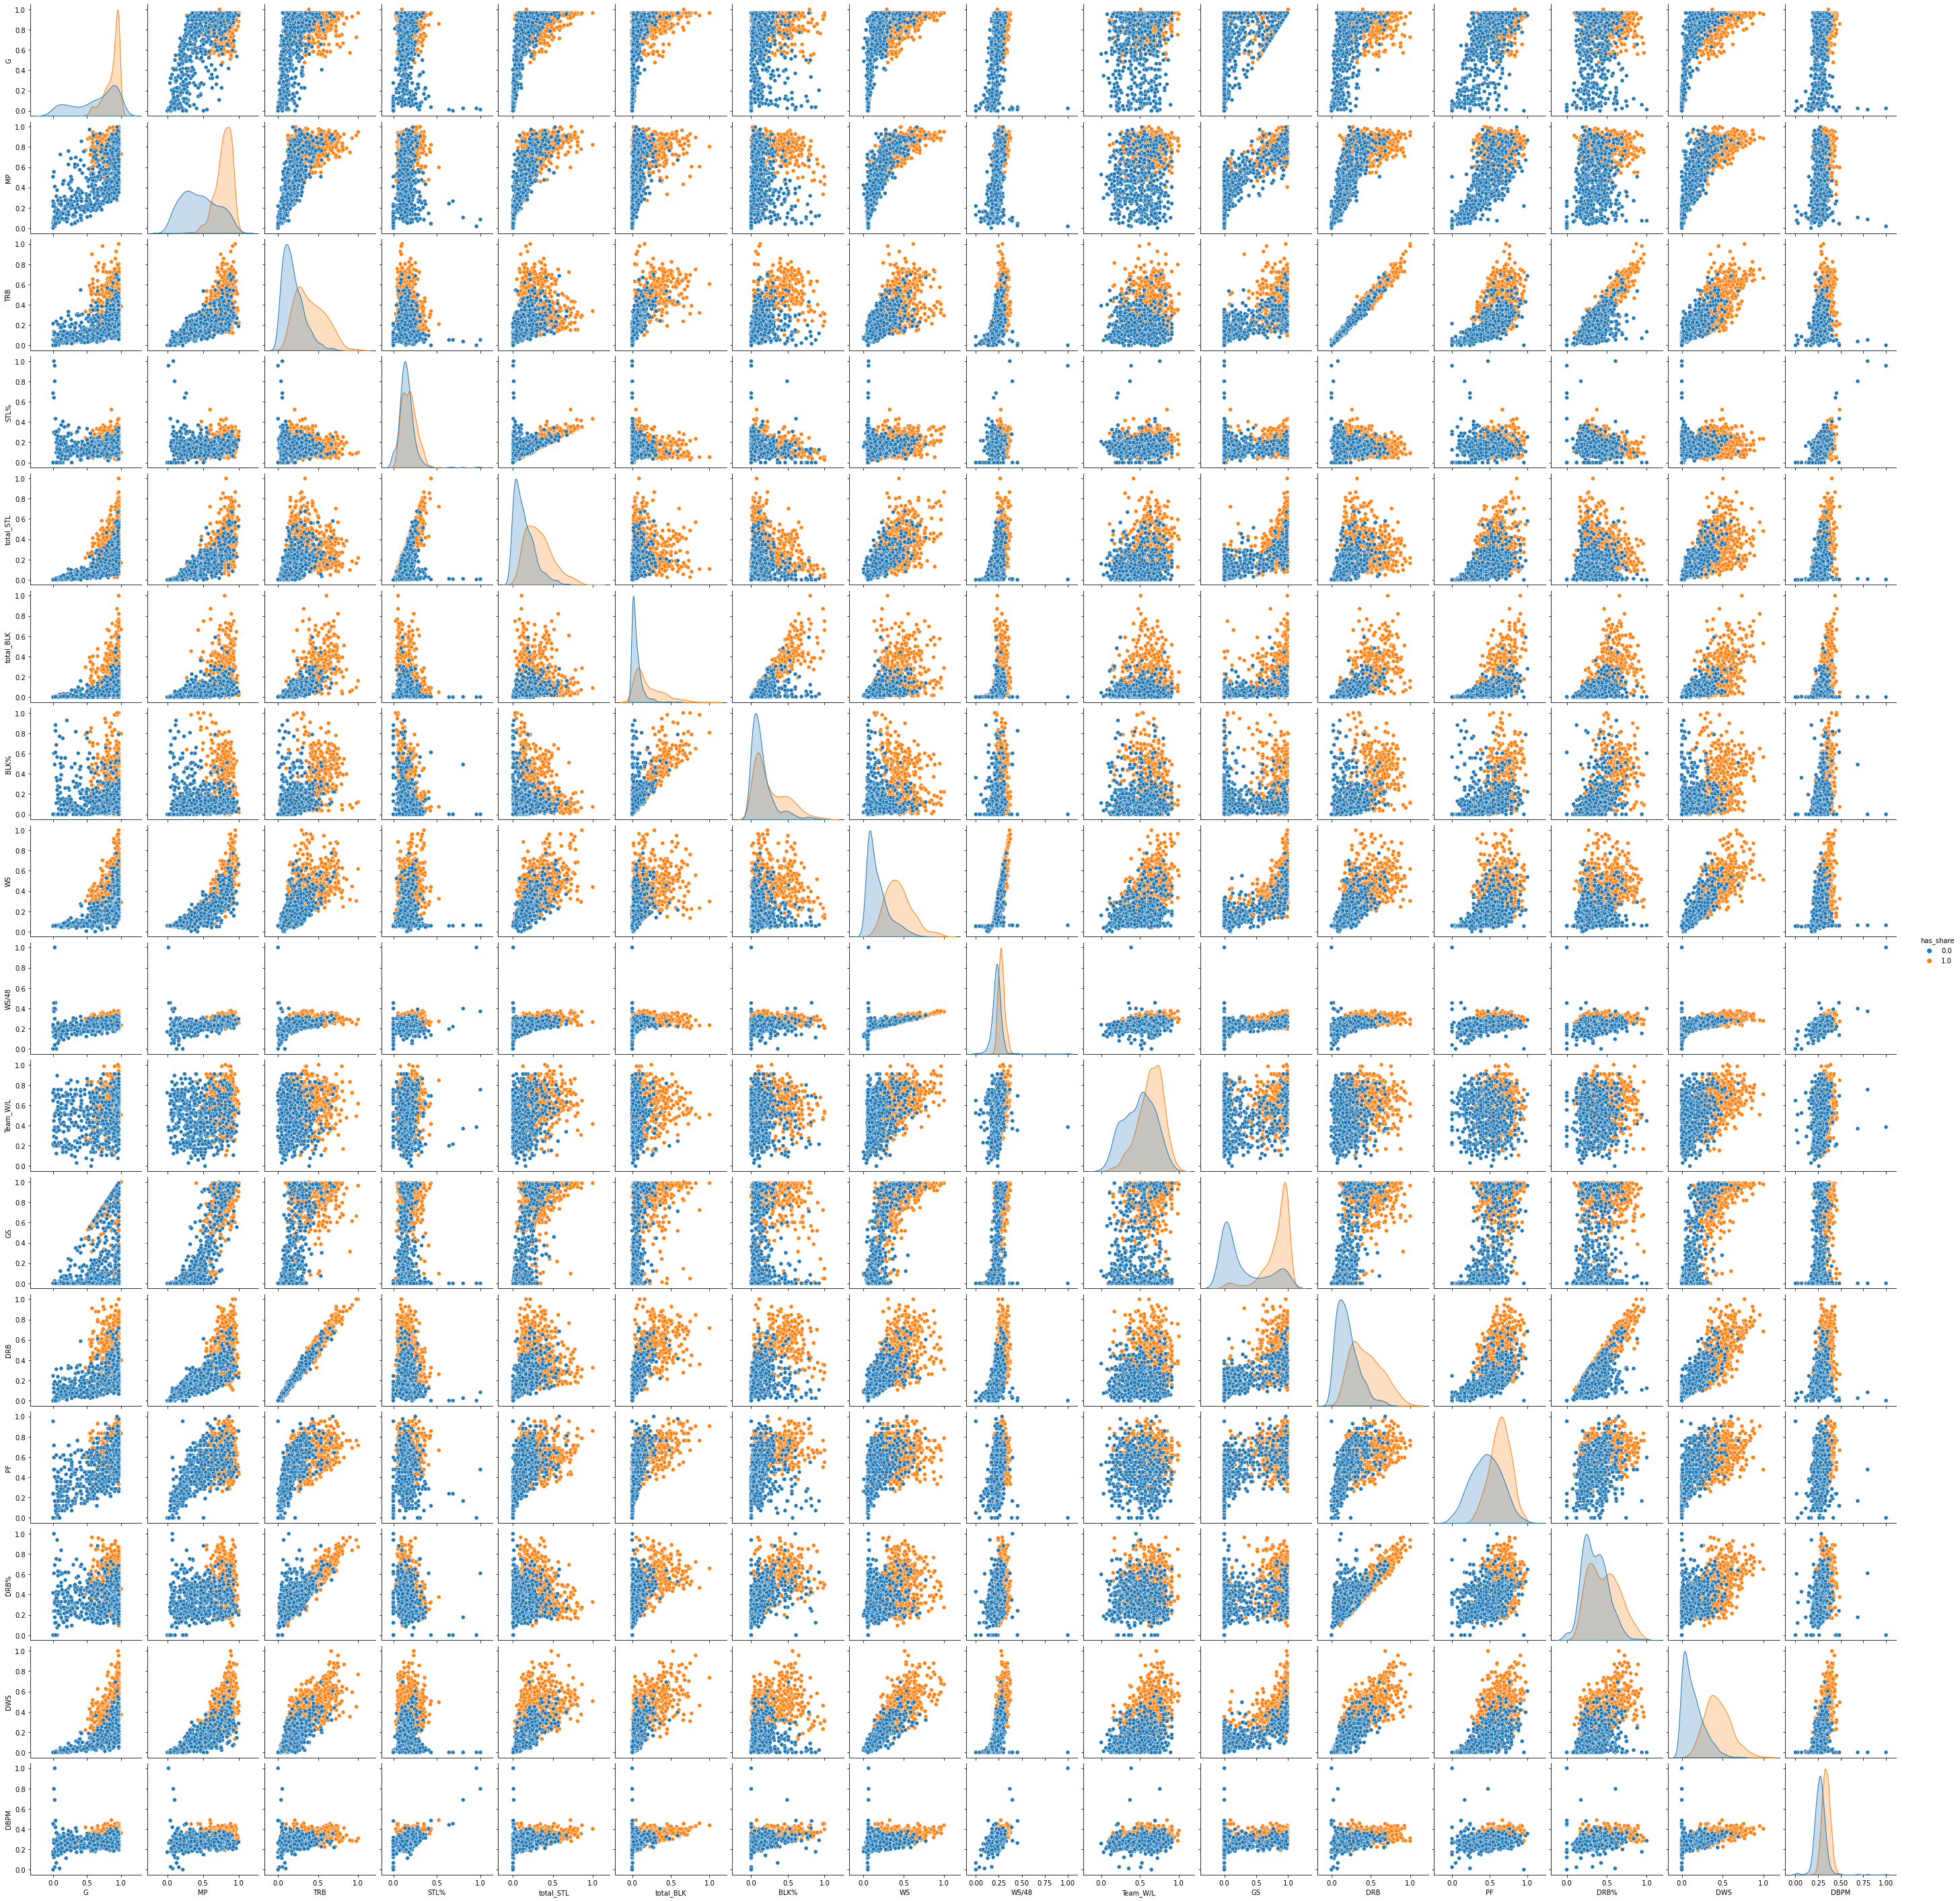

In [ ]:
temp = X_train.copy()
sns.pairplot(temp, hue = "has_share")

Based on the histograms:
- Games Played ('G'): Players must play a minimum amount of games to be considered for DPOY shares. (i.e. all players who have received DPOY shares have played a minimum number of 40 games)
  -  By similar logic, players who receive DPOY shares play a certain number of minutes per game ('MP').
- DPOY players usually have higher total rebounds, blocks and steals
- Position has little effect on shares

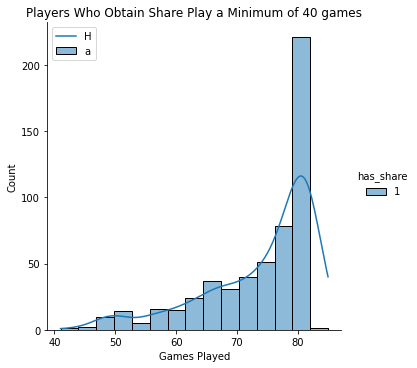

In [ ]:
sns.displot(data = X_train, x = 'G', kde = 'True', hue = 'has_share')
plt.title('Players Who Obtain Share Play a Minimum of 40 games')
plt.xlabel('Games Played')
plt.legend('Has share?')

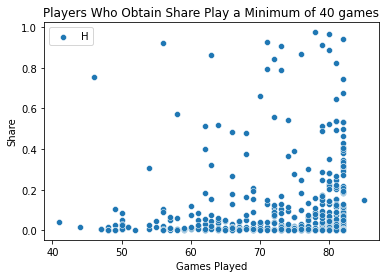

In [ ]:
temp = X_train.copy()
temp['Share'] = y_train


sns.scatterplot(data = temp, x = 'G', y = 'Share')
plt.title('Players Who Obtain Share Play a Minimum of 40 games')
plt.xlabel('Games Played')
plt.legend('Has share?')

Text(0.5, 6.79999999999999, 'Defensive Win Share')

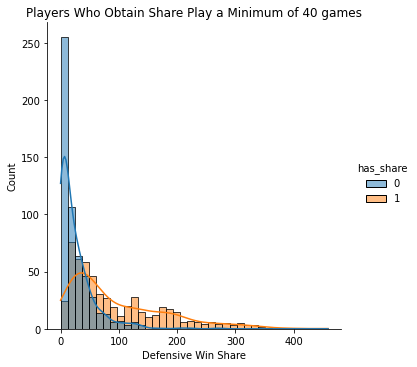

In [ ]:
sns.displot(data = X_train, x = 'total_BLK', kde = 'True', hue = 'has_share')
plt.title('Players Who Obtain Share Play a Minimum of 40 games')
plt.xlabel('Defensive Win Share')

In [ ]:
sns.displot(data = X_train, x = 'total_STL', kde = 'True', hue = 'has_share')
# plt.title('Players Who Obtain Share Play a Minimum of 40 games')
# plt.xlabel('Games Played')

Question: is the change in stats between a player's DPOY season and prior seasons a factor?

Hypothesis: Consider historic data based on the last x years, and see if the change in statistics is a factor.

Question: do DPOY's receive more shares if their addition to the team drastically improve their team's defensive rating?

Hypothesis: Consider historic team data and observe their defensive rating before and after they are added to the team.

Question: PCA and see if we have clusters.

Question: Analysing the players performance relative to other players in the same year.

Remember to note the investigation of trends.

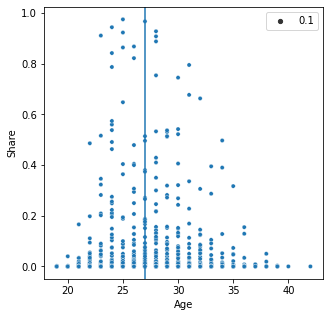

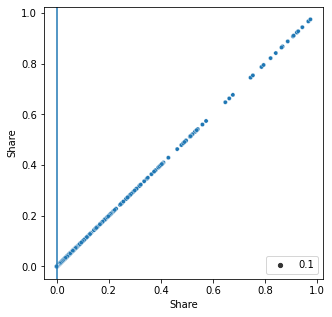

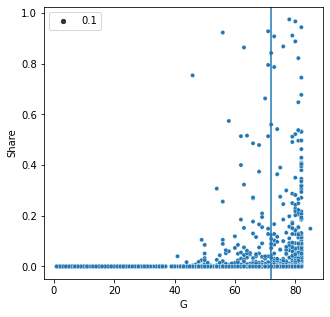

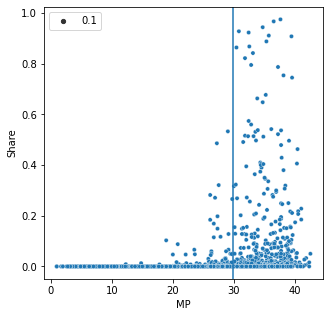

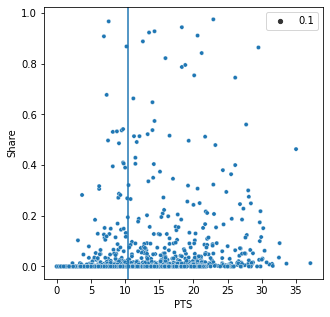

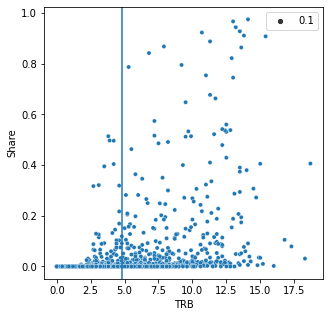

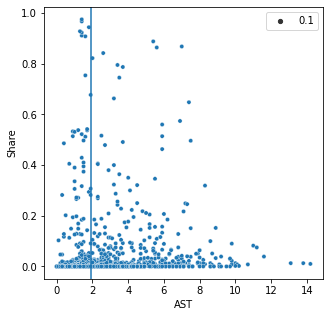

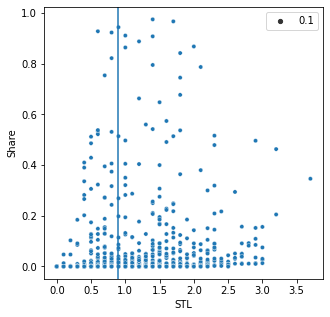

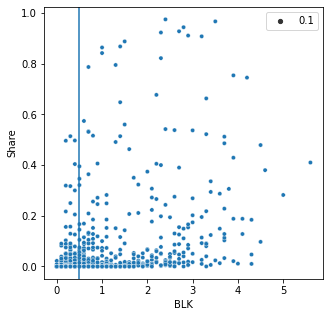

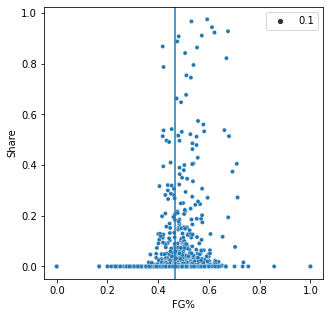

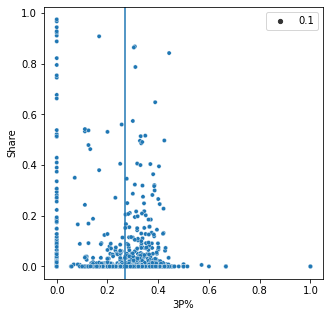

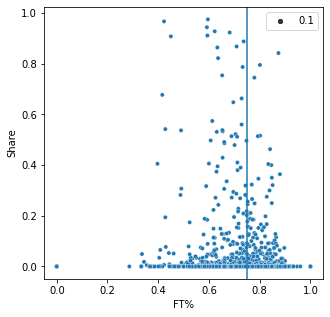

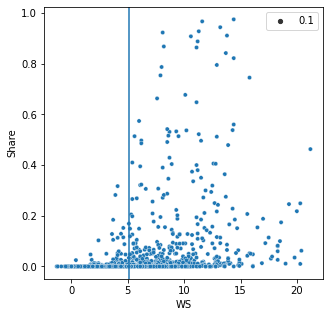

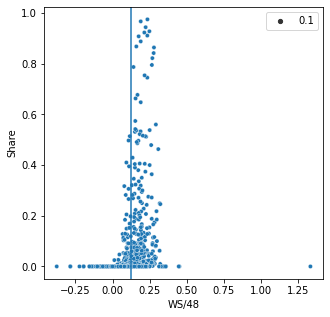

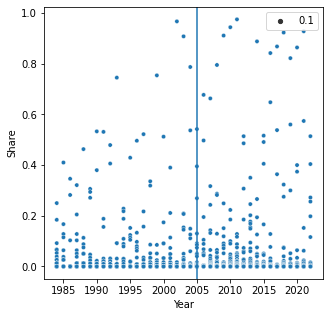

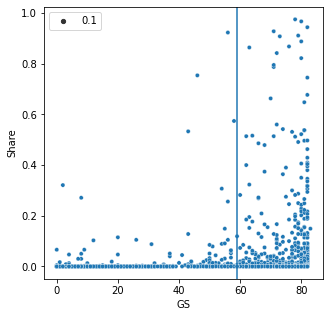

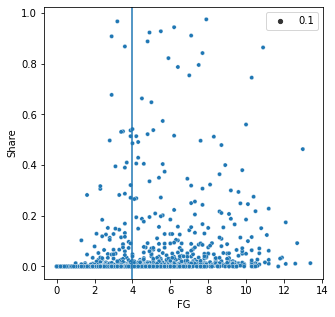

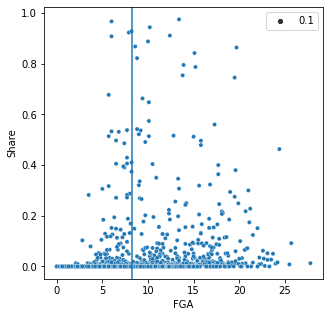

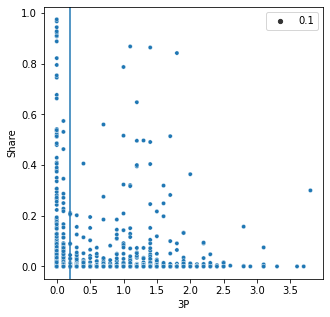

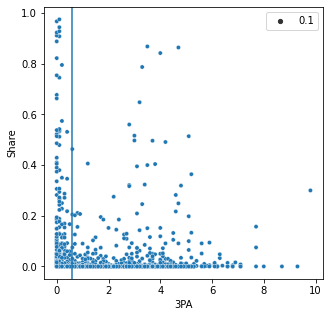

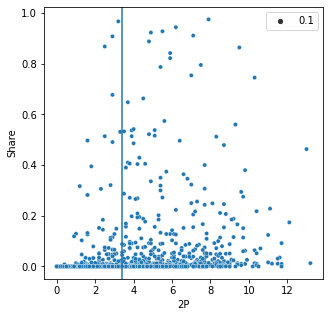

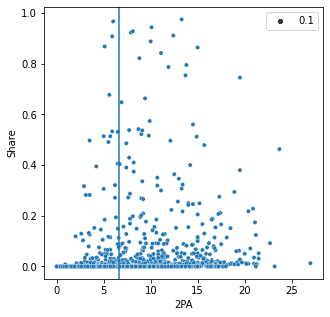

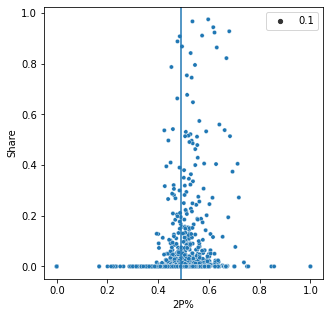

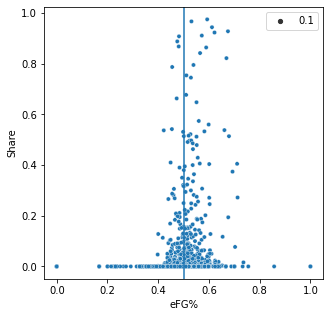

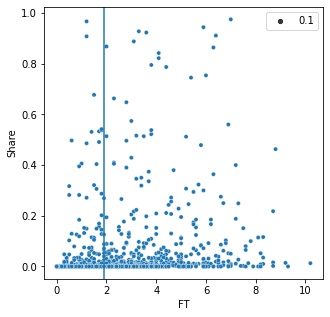

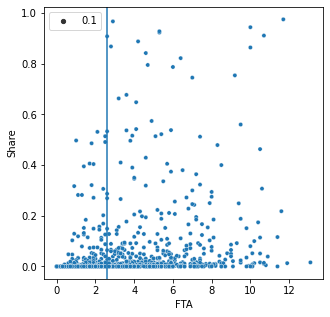

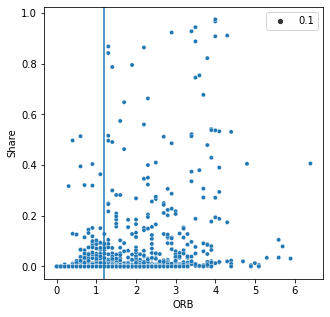

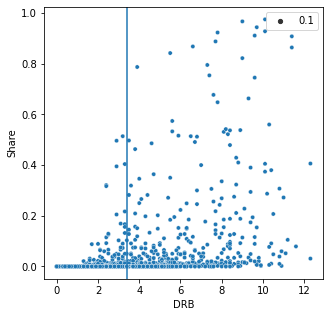

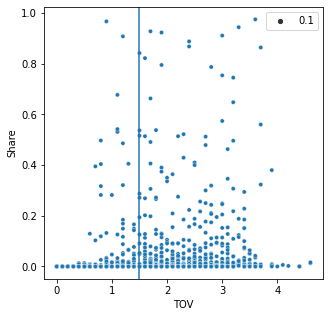

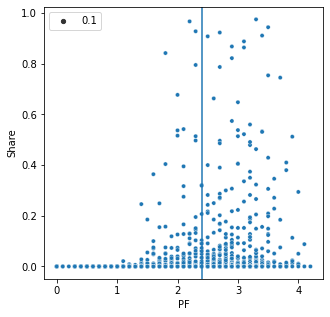

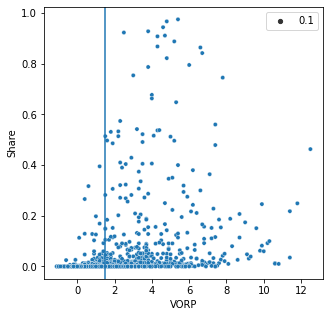

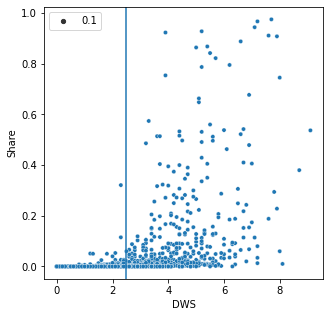

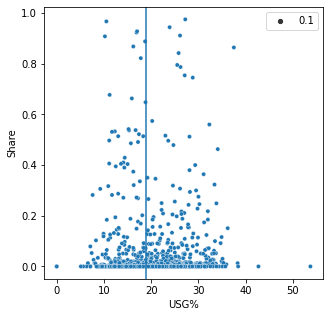

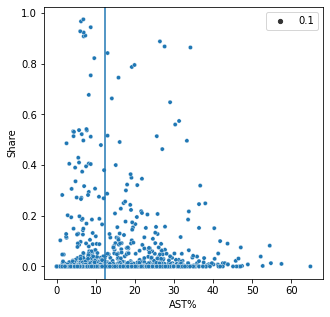

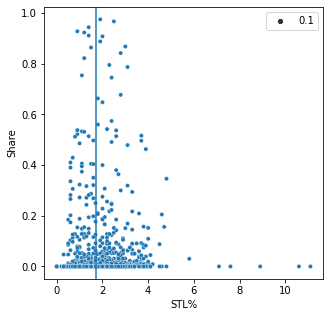

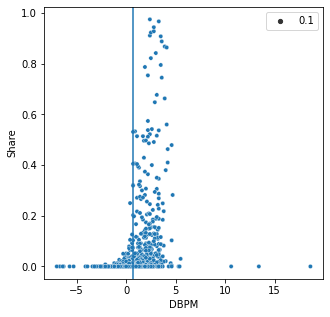

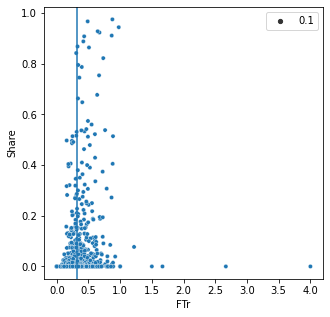

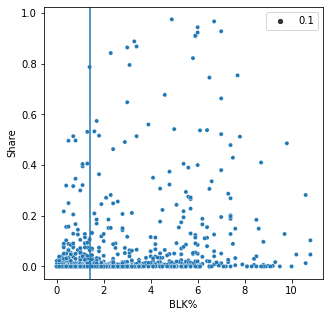

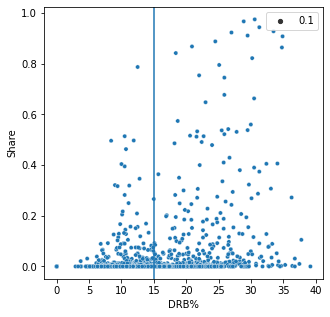

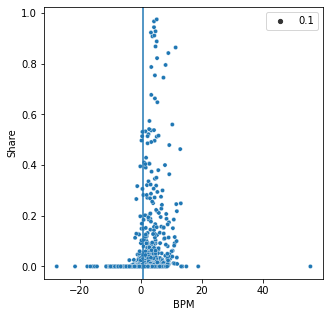

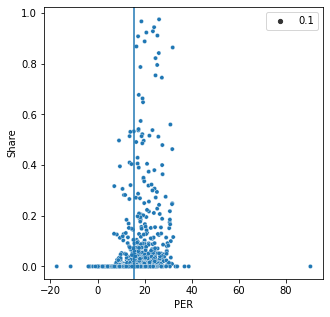

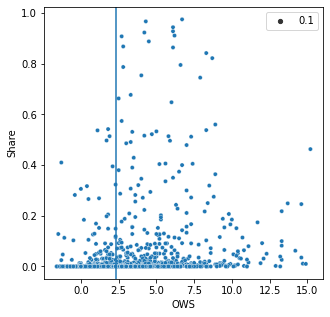

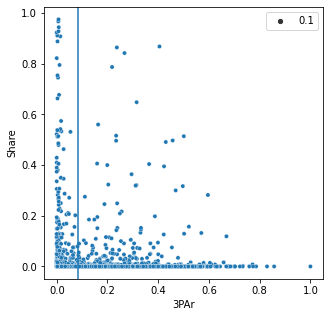

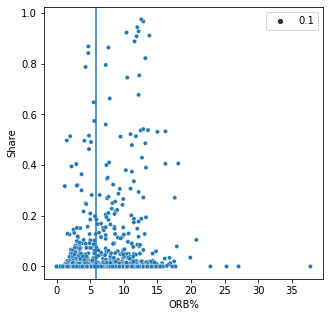

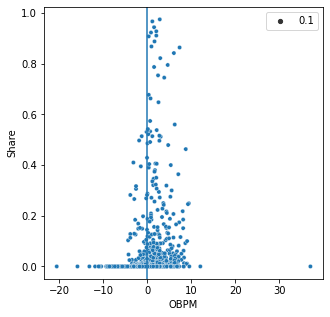

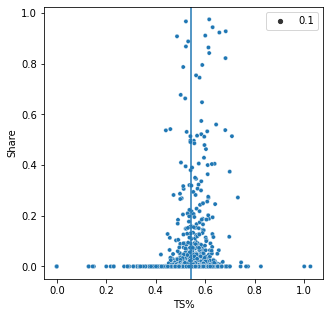

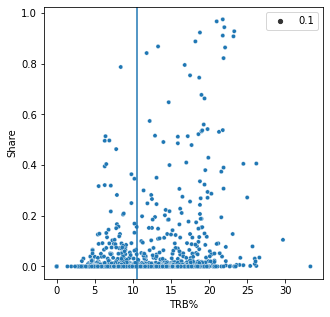

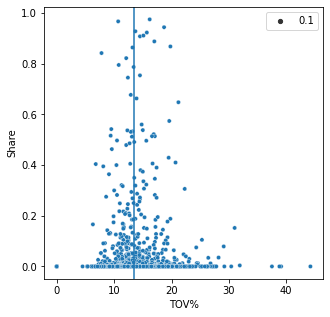

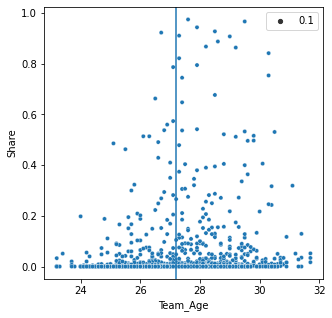

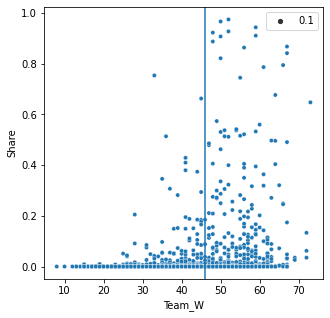

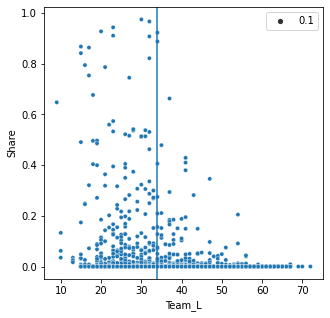

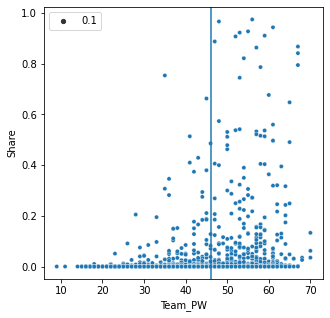

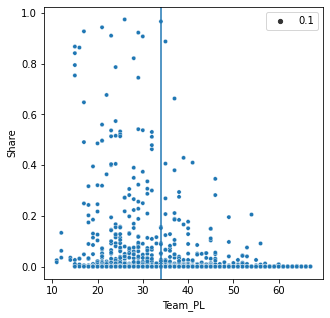

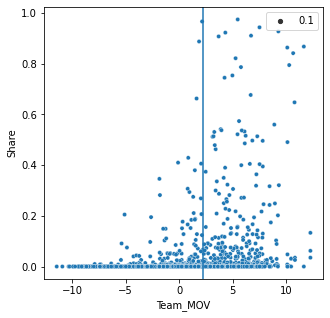

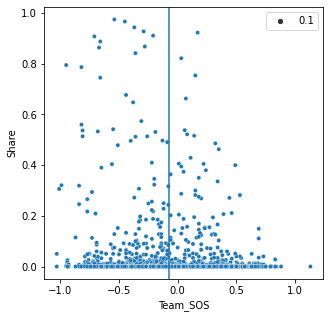

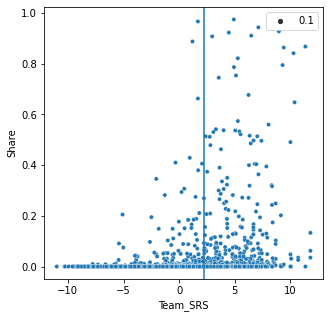

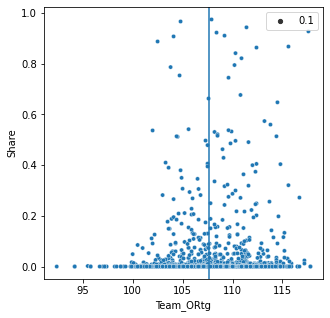

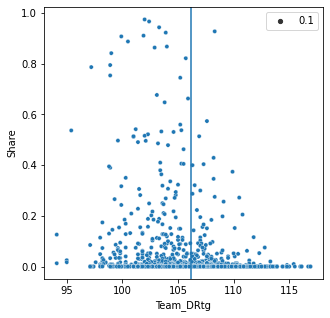

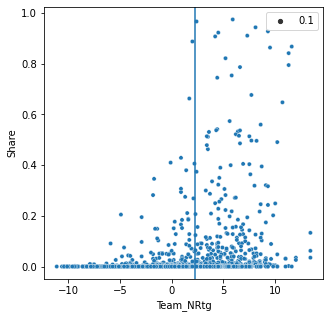

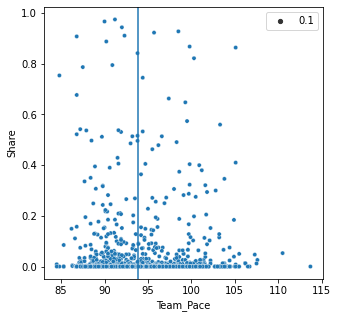

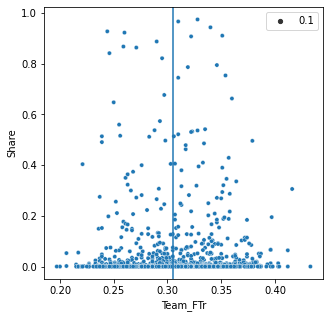

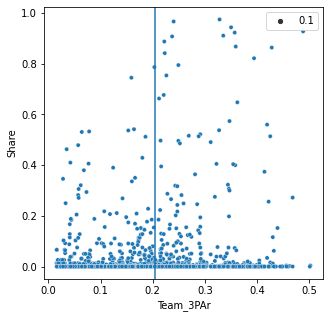

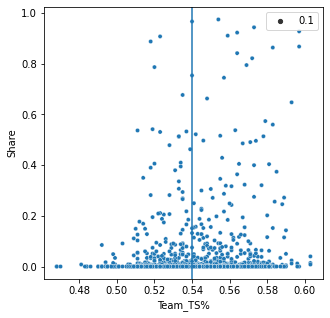

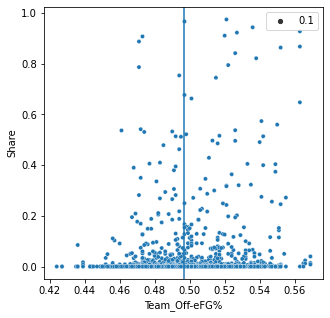

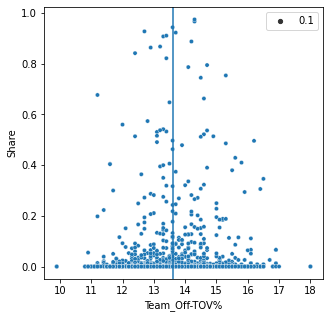

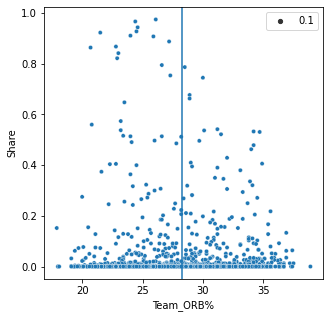

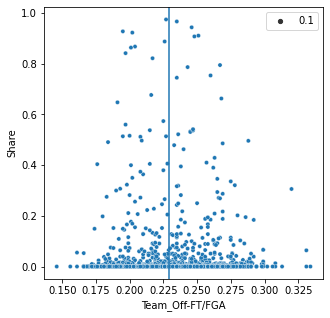

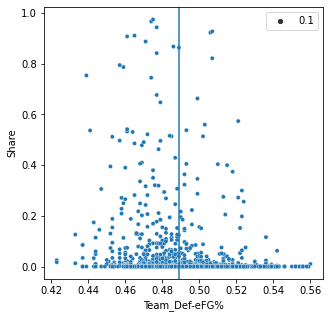

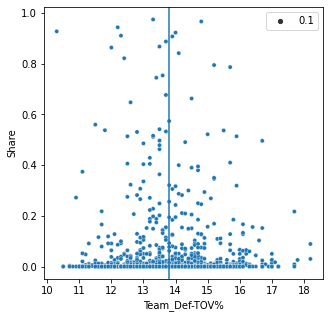

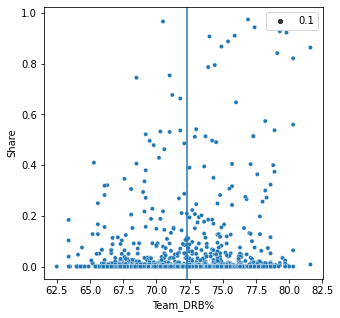

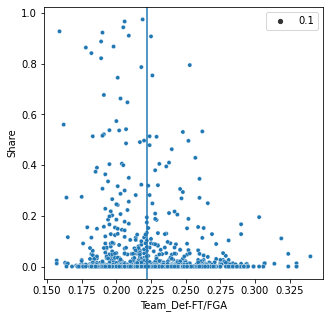

In [ ]:
for column in X_train[]:
   plt.figure(figsize = (5,5))
   plt.axvline(df[column].median())
   ax = sns.scatterplot(data = X_train, x = column, y = 'Share', marker = 'o', size = 0.1)

From G/Share: 